# MSc AI Project
by **Jaroslaw Janas** <br>
under supervision of **Dr. James McDermott**

## Environment

In [1]:
from google.colab import drive, runtime
from PIL import Image
import glob
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from keras.metrics import (MeanIoU, IoU, Precision, Recall)
from keras.backend import epsilon
from keras.losses import CategoricalCrossentropy
from keras.utils import (to_categorical, set_random_seed)
from keras.models import (Model, load_model)
from keras.callbacks import (EarlyStopping, ModelCheckpoint)
from keras import layers as ly

# !pip install -U tensorflow-addons
# import tensorflow_addons as tfa

from keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D,
                          Cropping2D, concatenate, Activation)

!pip install git+https://github.com/qubvel/segmentation_models
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

seed = 27
set_random_seed(27)

plt.rcParams['figure.dpi'] = 140

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-mp2s5mb2
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-mp2s5mb2
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33786 sha256=b8a22dc9463fc17e3131e90182234806000491550a04c89f7f5fe1dff599fb82
  Stored in directory: /tmp/pip-ephem-wheel-cache-mxoue8uk/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models
Segmentation Models: using `tf.keras` framework.


In [2]:
# From
# https://colab.research.google.com/notebooks/pro.ipynb
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 29 21:51:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading data

In [3]:
## Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

# Paths
drive_path = "/content/drive/MyDrive" # Do not change
internal_path = "Datasets"
folder_name = "medical-segmentation-vishwas-v2"

data_folder = "/content/data"
full_path = f"{data_folder}/{folder_name}"

In [5]:
# Download and unzip
if not os.path.exists(full_path):
    zip_path = f"{drive_path}/{internal_path}/{folder_name}.zip"

    !mkdir -p $data_folder
    !unzip $zip_path -d $data_folder &> /dev/null

    print("Loaded data!")
else:
    print("Data is already loaded!")

Loaded data!


In [6]:
# Locate images
image_paths = glob.glob(f"{full_path}/images/*.tiff")
mask_paths = glob.glob(f"{full_path}/masks/*.tiff")

print(f"Found {len(image_paths)} images")
print(f"Found {len(mask_paths)} masks")

Found 29 images
Found 29 masks


In [7]:
# Load image files
raw_images = []
raw_masks = []

for (image_path, mask_path) in zip(image_paths, mask_paths):
    image = Image.open(image_path)

    raw_images.append(np.array(image))

    mask = Image.open(mask_path)
    raw_masks.append(np.array(mask))

print(f"Opened {len(raw_images)} images")
print(f"Opened {len(raw_masks)} masks")

Opened 29 images
Opened 29 masks


## Visualize data

In [8]:
img_idx = 10
test_img = raw_images[img_idx]

# View test image
fig = plt.figure(figsize=(20, 20), facecolor="gray")
plt.axis('off')
plt.imshow(test_img)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

[0 1 2]


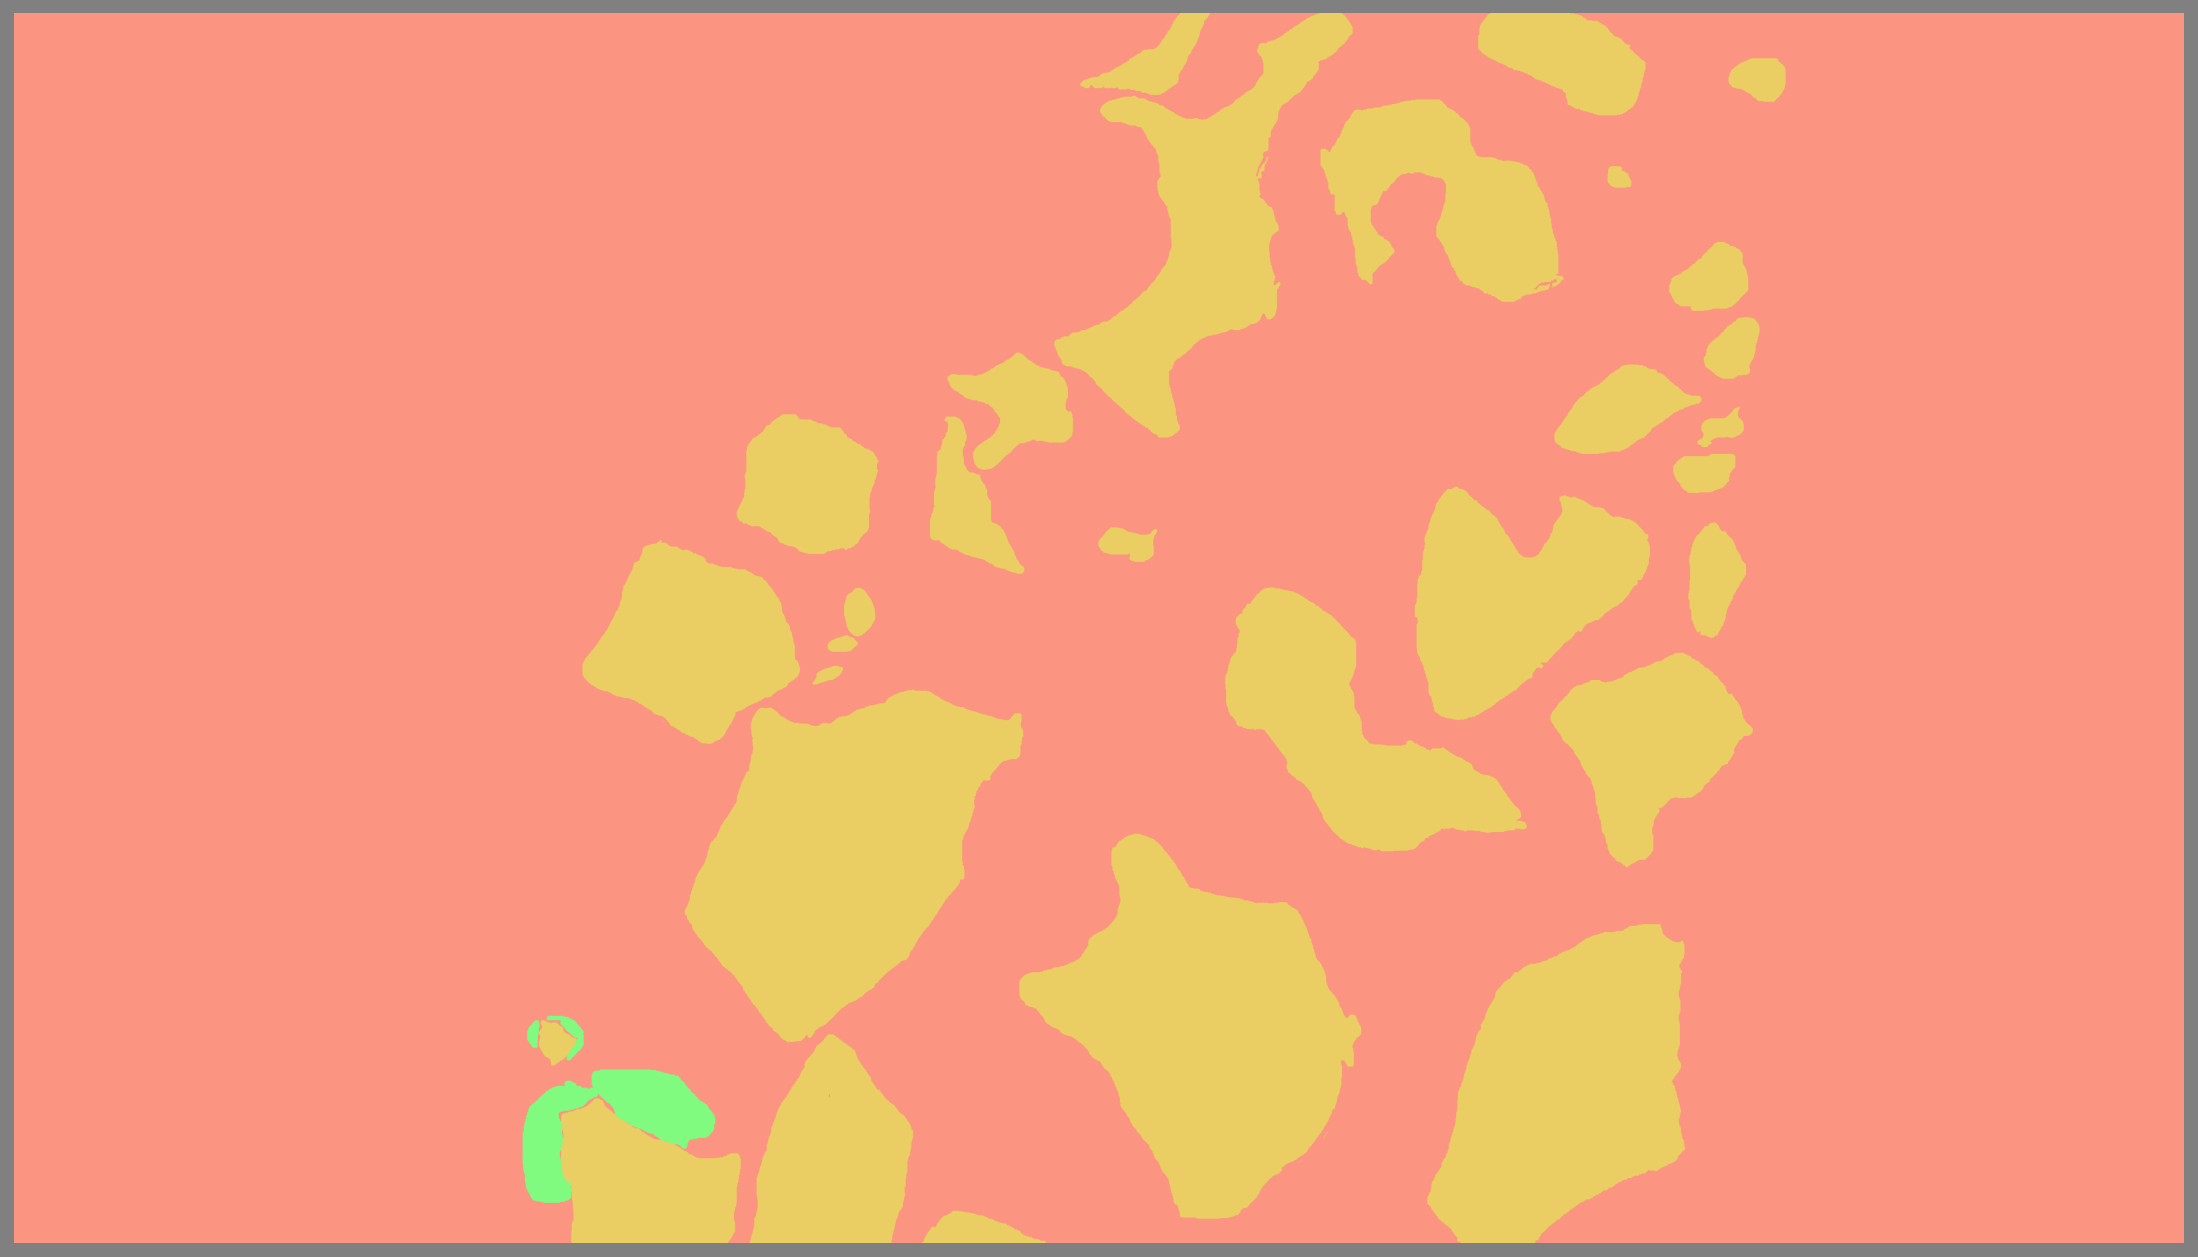

In [9]:
# Check classes
test_mask = raw_masks[img_idx]

classes = np.unique(test_mask)
print(classes)

# View test mask
# Colors
label_colormap = np.array([
    [251, 149, 129],    # 0 -> red
    [235, 206, 99],     # 1 -> yellow
    [128, 250, 127],    # 2 -> green
    [130, 177, 255]     # 3 -> blue
], dtype=np.uint8)

# Convert image to RGB
color_test_mask = label_colormap[test_mask]

# View test mask
fig = plt.figure(figsize=(20, 20), facecolor="grey")
plt.axis('off')
plt.imshow(color_test_mask)
plt.show()

## Class Freqency Analysis

In [10]:
# # Each mask has the same x and y size
# x_size, y_size = raw_masks[0].shape

# # Initialize a dictionary to store the class frequencies
# class_frequencies = {0: 0, 1: 0, 2: 0, 3: 0}

# # Iterate over each image and update class frequencies
# for mask in raw_masks:
#     for x in range(x_size):
#         for y in range(y_size):
#             class_value = mask[x, y]
#             class_frequencies[class_value] += 1

# # Compute the overall class frequencies
# total_pixels = len(raw_masks) * x_size * y_size
# global_class_frequencies = {class_value: count / total_pixels for class_value, count in class_frequencies.items()}

# print(global_class_frequencies)

global_class_frequencies = {
    0: 0.6597579615594891,
    1: 0.26493156386679134,
    2: 0.06425231562183063,
    3: 0.011058158951888945
}

global_class_frequencies_arr = [
    0.6597579615594891,
    0.26493156386679134,
    0.06425231562183063,
    0.011058158951888945
]

##Dataset patches
Since the raw images and masks have a resolution of `3840x2176` we need to split them into smaller patches first. Here we define a function/s that will take an image of some size and generate patches of some smaller size.

In [11]:
patch_img_width = 128
patch_img_height = 128

### Image2Patches functions

The below function splits the image into patches. It's is done with overlap, which means that if the lenght of the image cannot be perfectly divided into patches of the provided size then overlap will be introduced. However to avoid having all of the overlap in two images, it is spread over all patches equally (with exeception of last patch which might have a little bit bigger overlap).

This might improve data variance? It shouldn't matter much for training **CNNs** but it might be signigicant for training **ViTs**? But it also might make class imbalance worse, since edges are duplicated and the dominating classes are more likely to be overlapping. a no-overlap solution should be considered e.g. pathchify with step equal to patch size.


In [12]:
def partitioning_with_overlap(length, segment_size): # segment = a patch
    segment_list = [(0, segment_size)]

    num_segments = math.ceil(length / segment_size)
    # Since the fisrt segment is already done we have to -1
    num_segments -= 1

    remainder = length % segment_size

    if remainder == 0:
        overlap = 0
        overlap_step = 0
    else:
        overlap = segment_size - remainder
        overlap_step = math.ceil(overlap / num_segments)

    last_pos = segment_size
    for i in range(num_segments):
        # print(f"Overlap: {overlap}")

        # if on last iteration use up the full overlap
        # or if the next step is bigger than remaining overlap
        if i == num_segments-1 or overlap < overlap_step:
            start_pos = last_pos - overlap
            # if latter is the case we need overlap and overlap_step set to 0
            # it doesn't matter for the last iteration so no need for an if
            overlap = 0
            overlap_step = 0
        else:
            start_pos = last_pos - overlap_step

        end_pos = start_pos + segment_size
        segment_list += [(start_pos, end_pos)]

        last_pos = end_pos
        overlap -= overlap_step

    return segment_list


def patches_positions(img, patch_width, patch_height):
    # Images
    if len(img.shape) == 3:
        height, width, _ = img.shape
    else: # Masks
        height, width = img.shape

    x_cords = partitioning_with_overlap(width, patch_width)
    y_cords = partitioning_with_overlap(height, patch_height)

    return x_cords, y_cords

def image_to_patches(img, patch_width, patch_height):
    x_cords, y_cords = patches_positions(img, patch_width, patch_height)

    patches = []
    for y1, y2 in y_cords:
        row_patches = []
        for x1, x2 in x_cords:
            row_patches.append(img[y1:y2, x1:x2])
        patches.extend(row_patches)

    return patches

### Test patch positions

In [13]:
# Check patch segmentation

x_cords, y_cords = patches_positions(test_img, patch_img_width, patch_img_height)
patches_per_image = len(x_cords)*len(y_cords)
print(f"Number of patches in the image: {patches_per_image}")

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 20), facecolor="grey")
ax.axis('off')

# Show the image
ax.imshow(test_img)

for i, yy in enumerate(y_cords):
    for j, xx in enumerate(x_cords):

        x, width = xx[0], xx[1] - xx[0]
        y, height = yy[0], yy[1] - yy[0]

        # Alternate edge color
        if (i + j) % 2 == 0:
            edgecolor = "black"
            linewidth = 1
            alpha = 1
            zorder = 2
        else:
            edgecolor = "red"
            linewidth = 2
            alpha = 0 # set to 1 to see all squares
            zorder = 1

        rect = plt.Rectangle((x, y), width, height,
                             fill=False,
                             edgecolor=edgecolor,
                             linewidth=linewidth,
                             alpha=alpha,
                             zorder=zorder)
        ax.add_patch(rect)

# Show the plot
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Dataset to patches

In [14]:
patch_images = []
patch_masks = []

for img, mask in zip(raw_images, raw_masks):
    patch_images.extend(image_to_patches(img, patch_img_width, patch_img_height))
    patch_masks.extend(image_to_patches(mask, patch_img_width, patch_img_height))

print(f"Split images into {len(patch_images)} patch images")
print(f"Shape: {patch_images[0].shape}")
print(f"Split masks into {len(patch_masks)} patch masks")
print(f"Shape: {patch_masks[0].shape}")

# Test if counts match expected values
img_patch_count = len(patch_images)
expected_patch_count = patches_per_image * len(raw_images)

if img_patch_count != expected_patch_count:
    raise ValueError(f"Patch count {img_patch_count} is \
    not as expected: {expected_patch_count}")

mask_patch_count = len(patch_masks)
if img_patch_count != mask_patch_count:
    raise ValueError(f"The number if images {img_patch_count} does not match \
    the number of masks {mask_patch_count}")

patch_images = np.array(patch_images)

# Free memory
del raw_images
del raw_masks

Split images into 14790 patch images
Shape: (128, 128, 3)
Split masks into 14790 patch masks
Shape: (128, 128)


## One-hot-encoding mask

In [15]:
# Convert masks to 1 hot encoding
labels = to_categorical(patch_masks, num_classes=4, dtype="uint8")
print(labels.shape)

# Free memory
# del patch_masks

(14790, 128, 128, 4)


## Label2ColorImg

In [16]:
def label_to_color_image(label):

    # Create an empty composite image
    composite_image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

    # Assign colors to each channel
    for channel_index in range(label.shape[2]): # number of labels
        channel = label[:, :, channel_index]
        color = label_colormap[channel_index] # define the color to use for channel_index
        composite_image[channel == 1] = color

    return composite_image

##

## Model

Heavily based/copied on [this](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

### Hyperparameters

#### Model

In [17]:
image_size = 128
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 192
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [9216] #[4096] # Size of the dense layers of the final classifier


#### Augmentation & Training

In [18]:
patience = 7
# learning_rate = 1e-5
learning_rate = 5e-5
# weight_decay = 5e-8
num_epochs = 52

batch_size = 4
validation_split = 0.15
test_split = 0.15

random_rotation = (-0.8, 0.8) # 0.6π = 35° | 0.8π = 46°
flip_mode = "horizontal_and_vertical"
vert_shift = (-0.2, 0.2) # 0.2 = 20%
horz_shift = (-0.2, 0.2) # 0.2 = 20%
vert_zoom = (-0.1, 0.1)
horz_zoom = (-0.1, 0.1)
interpolation = "nearest"
fill_mode = "reflect"

### Data augmentation

In [19]:
print(patch_images.shape)
print(labels.shape)

(14790, 128, 128, 3)
(14790, 128, 128, 4)


#### Augment class

In [20]:
# Define augmentation function
class AugmentImages():
    def __init__(self, seed):
        self.random_flip = ly.RandomFlip(
            mode=flip_mode,
            seed=seed
        )
        self.rand_trans = ly.RandomTranslation(
            vert_shift,
            horz_shift,
            fill_mode=fill_mode,
            interpolation=interpolation,
            seed=seed
        )
        self.random_rot = ly.RandomRotation(
            random_rotation,
            fill_mode=fill_mode,
            interpolation=interpolation,
            seed=seed
        )
        self.rand_zoom = ly.RandomZoom(
            vert_zoom,
            horz_zoom,
            fill_mode=fill_mode,
            interpolation=interpolation,
            seed=seed
        )

    def __call__(self, image, mask):
        # Merge to ensure the same transformations are applied
        merged = tf.concat([image, mask], axis=-1)

        merged = self.random_flip(merged)
        merged = self.rand_trans(merged)
        merged = self.random_rot(merged)
        merged = self.rand_zoom(merged)

        input, mask = tf.split(merged, [3, 4], axis=-1)

        return input, mask

augment_images = AugmentImages(seed)

#### Augmentation class check

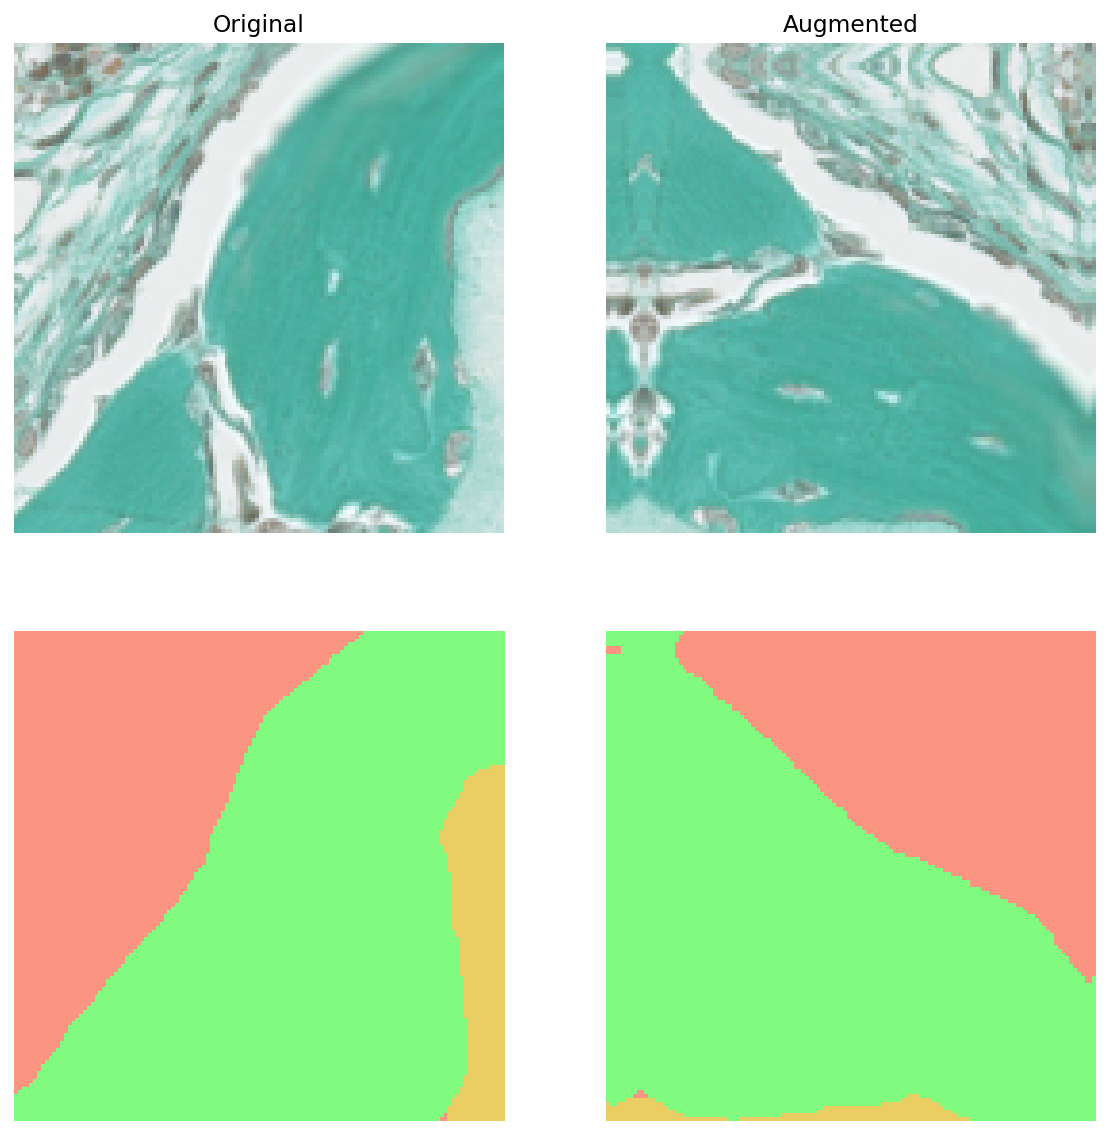

In [21]:
idx = 861

test_image = patch_images[idx]
test_label = labels[idx]

aug_image, aug_label = augment_images(test_image, test_label)

# Create a figure
fig, axs = plt.subplots(2, 2, figsize=(10, 10))#, facecolor="grey")
axs[0][0].axis('off')
axs[1][0].axis('off')
axs[0][1].axis('off')
axs[1][1].axis('off')

# Display the original image
axs[0][0].imshow(test_image)
axs[0][0].set_title("Original")

# Display the original label
original_label = label_to_color_image(test_label)
axs[1][0].imshow(original_label)

# Display the predicted label
axs[0][1].imshow(aug_image.numpy().astype("uint8"))
axs[0][1].set_title("Augmented");

# Display the original image
axs[1][1].imshow(label_to_color_image(aug_label))

#### Convert to TF Dataset Obj

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((patch_images, labels))
shuffled_dataset = dataset.shuffle(len(dataset), seed=seed)

print(f"Dataset size: {len(shuffled_dataset)}")

del dataset

Dataset size: 14790


#### Augmentation setup

In [23]:
auto = tf.data.AUTOTUNE

# Split the dataset into train and validation sets
total_samples = len(shuffled_dataset)
num_training_samples = int(total_samples * (1 - validation_split - test_split))
num_validation_samples = int(total_samples * validation_split)

train_dataset = shuffled_dataset.take(num_training_samples)
other_dataset = shuffled_dataset.skip(num_training_samples)

validation_dataset = other_dataset.take(num_validation_samples)
test_dataset = other_dataset.skip(num_validation_samples)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(validation_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


# Apply augmentation using Dataset.map()
aug_train_dataset = (train_dataset
                    .map(
                        augment_images,
                        num_parallel_calls=tf.data.AUTOTUNE
                    )
                    .batch(batch_size)
                    # .cache()
                    .shuffle(
                        len(train_dataset),
                        seed=seed,
                        reshuffle_each_iteration=True
                    )
                    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = (validation_dataset
                        #  .map(
                        #       augment_images,
                        #       num_parallel_calls=tf.data.AUTOTUNE
                        #  )
                         .batch(batch_size)
                         .cache()
                         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = (test_dataset
                        #  .map(
                        #       augment_images,
                        #       num_parallel_calls=tf.data.AUTOTUNE
                        #  )
                         .batch(batch_size)
                         .cache()
                         .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# del shuffled_dataset
del other_dataset

Train dataset size: 10353
Validation dataset size: 2218
Test dataset size: 2219


#### Augmentation Check

(128, 128, 3)
(128, 128, 4)


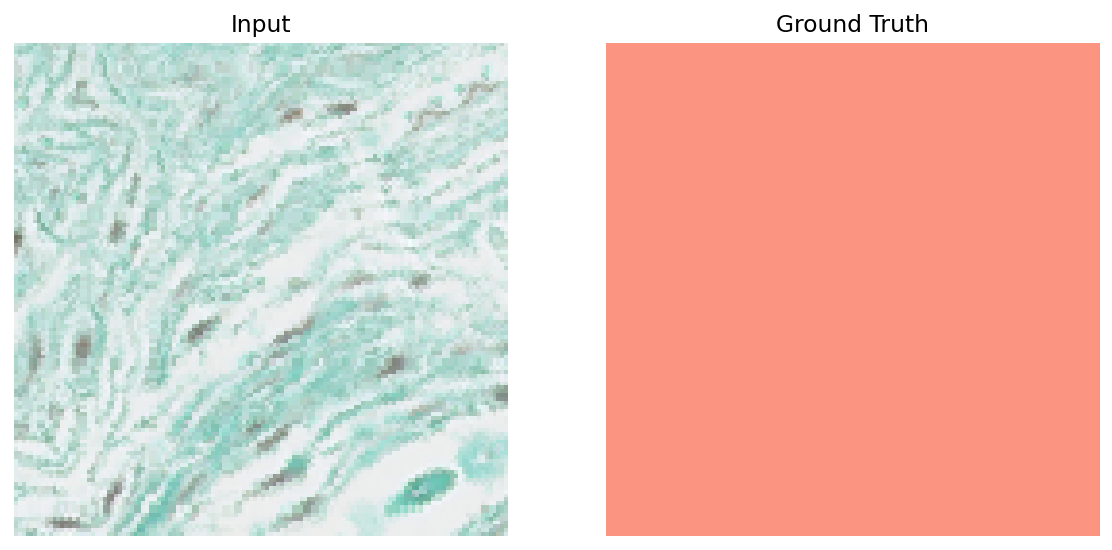

In [24]:
batch_images, batch_labels = next(iter(aug_train_dataset.take(1)))

test_image = batch_images[0]
test_label = batch_labels[0]
print(test_image.shape)
print(test_label.shape)

# Create a figure
fig, axs = plt.subplots(1, 2, figsize=(10, 5))#, facecolor="grey")
axs[0].axis('off')
axs[1].axis('off')

# Display the original image
axs[0].imshow(np.squeeze(test_image).astype(int))
axs[0].set_title("Input")

# Display the original label
test_label = label_to_color_image(test_label)
axs[1].imshow(test_label)
axs[1].set_title("Ground Truth");

Based on [this stackoverflow](https://stackoverflow.com/questions/74764831/preprocessing-layers-with-seed-not-producing-the-same-data-augmentation-for-imag) post, it's a bit of a hack but it works.

I should probably do [this](https://keras.io/guides/keras_cv/custom_image_augmentations/) instead, but it's too much work at the moment, will come back to this.

### Implement multilayer perceptron (MLP)

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = ly.Dense(units, activation=tf.nn.gelu)(x)
        x = ly.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer
This is not the same patch creation as in [dataset patches](https://colab.research.google.com/drive/1Rpcq_Mha2ryqSXiG3lFFq8oud0W4sDE4?authuser=1#scrollTo=Mx9mhHw6JX59)

In [26]:
class Patches(ly.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]

        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])

        return patches

### Test patch creation

Image shape: (128, 128, 3)
Label shape: (128, 128, 4)
Image size: 128 X 128
Patch size: 8 X 8
Patches shape: (1, 256, 192)
Patches per image: 256
Elements per patch: 192


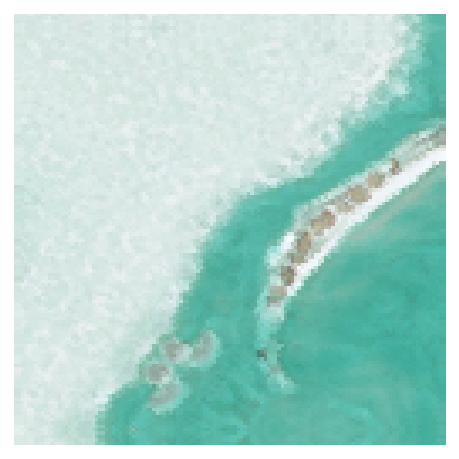

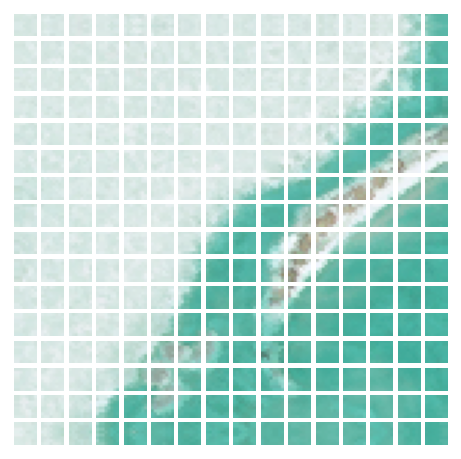

In [27]:
plt.figure(figsize=(4, 4))

batch_images, batch_labels = next(iter(aug_train_dataset.take(1)))

test_image = batch_images[0]
test_label = batch_labels[0]

print(f"Image shape: {test_image.shape}")
print(f"Label shape: {test_label.shape}")

plt.imshow(test_image.numpy().astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([test_image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches shape: {patches.shape}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implement the patch encoding layer

In [28]:
class PatchEncoder(ly.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = ly.Dense(units=projection_dim)
        self.position_embedding = ly.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

### ViT Model

In [29]:
def create_vit_classifier(input_shape):
    inputs = ly.Input(shape=input_shape)
    # inputs = ly.Resizing(128, 128, interpolation="bilinear")(inputs)

    rescaled = ly.Rescaling(scale=1./255, offset=0.0)(inputs)

    # Create patches.
    patches = Patches(patch_size)(rescaled)

    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    print("Creating multiple layers of the Transformer block")
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = ly.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = ly.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = ly.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = ly.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = ly.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = ly.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = ly.Flatten()(representation)
    representation = ly.Dropout(0.5)(representation)

    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Decoder
    # m1 = ly.Reshape((8, 8, 64))(features)
    # m1 = ly.Reshape((12, 12, 64))(features)
    m1 = ly.Reshape((12, 12, 64))(features)


    # up1 = UpSampling2D((2, 2))(m1)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(m1)
    conv10 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv11 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv10)

    up2 = UpSampling2D((2, 2))(conv11)
    conv2 = Conv2D(32, (5, 5), activation='relu', padding='same')(up2)
    conv20 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv2)
    conv22 = Conv2D(32, (5, 5), activation='relu', padding='same')(conv20)

    up3 = UpSampling2D((2, 2))(conv22)
    conv3 = Conv2D(16, (3, 3), activation='relu', padding='same')(up3)
    conv30 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv3)
    conv33 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv30)

    up4 = UpSampling2D((2, 2))(conv33)
    conv4 = Conv2D(8, (3, 3), activation='relu', padding='same')(up4)
    conv40 = Conv2D(8, (3, 3), activation='relu', padding='same')(up4)
    conv44 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv40)

    up5 = UpSampling2D((2, 2))(conv44)
    conv5 = Conv2D(4, (3, 3), activation='relu', padding='same')(up5)
    conv50 = Conv2D(4, (3, 3), activation='relu', padding='same')(up5)
    conv55 = Conv2D(4, (3, 3), activation='relu', padding='same')(conv50)

    # output_layer = ly.Softmax(axis=-1)(conv55)

    softmax = ly.Softmax(axis=-1)(conv55)
    output_layer = ly.Resizing(128, 128, interpolation="nearest")(softmax)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

### Model Summary

In [30]:
# Define the model
model = create_vit_classifier(
    input_shape=(patch_img_width, patch_img_height, 3)
)

model.summary()

Creating multiple layers of the Transformer block
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['rescaling[0][0]']              
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 256, 

## Loss

In [31]:
def weighted_categorical_crossentropy(class_frequencies):
    total_samples = sum(class_frequencies.values())
    num_classes = len(class_frequencies)
    class_weights = {cls: total_samples / (num_classes * freq) for cls, freq in class_frequencies.items()}
    print(class_weights)

    def loss(y_true, y_pred):
        loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        class_indices = tf.argmax(y_true, axis=-1)
        weighted_loss = loss * tf.gather(list(class_weights.values()), class_indices)
        #return tf.reduce_mean(weighted_loss) # not needed with Adam opt
        return weighted_loss

    return loss

wcc_loss = weighted_categorical_crossentropy(global_class_frequencies)

{0: 0.3789268406993797, 1: 0.943639921008812, 2: 3.8909103521096906, 3: 22.607741585889865}


In [32]:
# dice_loss = sm.losses.DiceLoss(class_weights=global_class_frequencies_arr)
dice_loss = sm.losses.DiceLoss()

# dice_loss_cast = lambda y_true, y_pred: dice_loss(
#     tf.cast(y_true, dtype=tf.float32),
#     y_pred
# )

In [33]:
focal_loss = sm.losses.CategoricalFocalLoss()

# focal_loss_cast = lambda y_true, y_pred: focal_loss(
#     tf.cast(y_true, dtype=tf.float32),
#     y_pred
# )

In [34]:
focal_dice_loss = dice_loss + focal_loss * 4

# focal_dice_loss_cast = lambda y_true, y_pred: focal_dice_loss(
#     tf.cast(y_true, dtype=tf.float32),
#     y_pred
# )

def focal_dice_loss_cast (y_true, y_pred):
    return focal_dice_loss(
        tf.cast(y_true, dtype=tf.float32),
        y_pred
    )

## IOU Score

In [35]:
mean_iou = MeanIoU(
    num_classes=4,
    name="mean_iou",
    sparse_y_true=False,
    sparse_y_pred=False,
    axis=-1
)

In [36]:
one_iou = IoU(
    num_classes=4,
    target_class_ids=[0],
    name="1_iou",
    sparse_y_true=False,
    sparse_y_pred=False,
    axis=-1
)

two_iou = IoU(
    num_classes=4,
    target_class_ids=[1],
    name="2_iou",
    sparse_y_true=False,
    sparse_y_pred=False,
    axis=-1
)

three_iou = IoU(
    num_classes=4,
    target_class_ids=[2],
    name="3_iou",
    sparse_y_true=False,
    sparse_y_pred=False,
    axis=-1
)

four_iou = IoU(
    num_classes=4,
    target_class_ids=[3],
    name="4_iou",
    sparse_y_true=False,
    sparse_y_pred=False,
    axis=-1
)

## Precision & Recall

In [37]:
precision = Precision(name="precision")
recall = Recall(name="recall")

## Training

In [38]:
# steps = int(patch_images.shape[0] / batch_size)

In [39]:
# Compile the model
model.compile(
    # optimizer=tf.optimizers.AdamW(
    #     learning_rate=learning_rate,
    #     weight_decay=weight_decay
    # ),
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=focal_dice_loss_cast,
    metrics=["accuracy", mean_iou, precision, recall, one_iou, two_iou,
             three_iou, four_iou]
)

# Define early stopping criteria
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=patience,
    restore_best_weights=True
)

early_stopping2 = EarlyStopping(
    monitor="val_mean_iou",
    patience=2,
    restore_best_weights=True,
    start_from_epoch=45,
)

# Train the model
history = model.fit(
    aug_train_dataset,
    epochs=num_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, early_stopping2]
)

Epoch 1/52
2589/2589 [==============================] - 237s 67ms/step - loss: 0.8855 - accuracy: 0.6599 - mean_iou: 0.1810 - precision: 0.7384 - recall: 0.5285 - 1_iou: 0.6664 - 2_iou: 0.0570 - 3_iou: 7.6002e-05 - 4_iou: 4.8851e-04 - val_loss: 0.8128 - val_accuracy: 0.6597 - val_mean_iou: 0.1940 - val_precision: 0.7615 - val_recall: 0.5758 - val_1_iou: 0.6901 - val_2_iou: 0.0859 - val_3_iou: 0.0000e+00 - val_4_iou: 0.0000e+00
Epoch 2/52
2589/2589 [==============================] - 183s 64ms/step - loss: 0.8012 - accuracy: 0.6576 - mean_iou: 0.2277 - precision: 0.7283 - recall: 0.6063 - 1_iou: 0.6761 - 2_iou: 0.0465 - 3_iou: 0.1852 - 4_iou: 0.0028 - val_loss: 0.7401 - val_accuracy: 0.7017 - val_mean_iou: 0.3421 - val_precision: 0.7242 - val_recall: 0.6665 - val_1_iou: 0.6897 - val_2_iou: 0.0140 - val_3_iou: 0.6648 - val_4_iou: 2.0470e-05
Epoch 3/52
2589/2589 [==============================] - 184s 64ms/step - loss: 0.7403 - accuracy: 0.7024 - mean_iou: 0.3424 - precision: 0.7235 - reca

## Save/Load

In [51]:
model.save("/content/drive/MyDrive/Colab Notebooks/AI Project/Models/ViT Bone Segmentation - mixed loss, semi balanced loss")

In [41]:
# model = load_model(
#     "/content/drive/MyDrive/Colab Notebooks/AI Project/Models/ViT Bone Segmentation - mixed loss, semi balanced loss",
#     compile=False
# )

## Image Test

In [42]:
# Prediction processing
def pred_processing(pred):
    m_pred = np.argmax(pred, axis=-1)
    one_hot_pred = to_categorical(m_pred, num_classes=4, dtype="uint8")
    rgb_pred = label_to_color_image(one_hot_pred)

    return rgb_pred

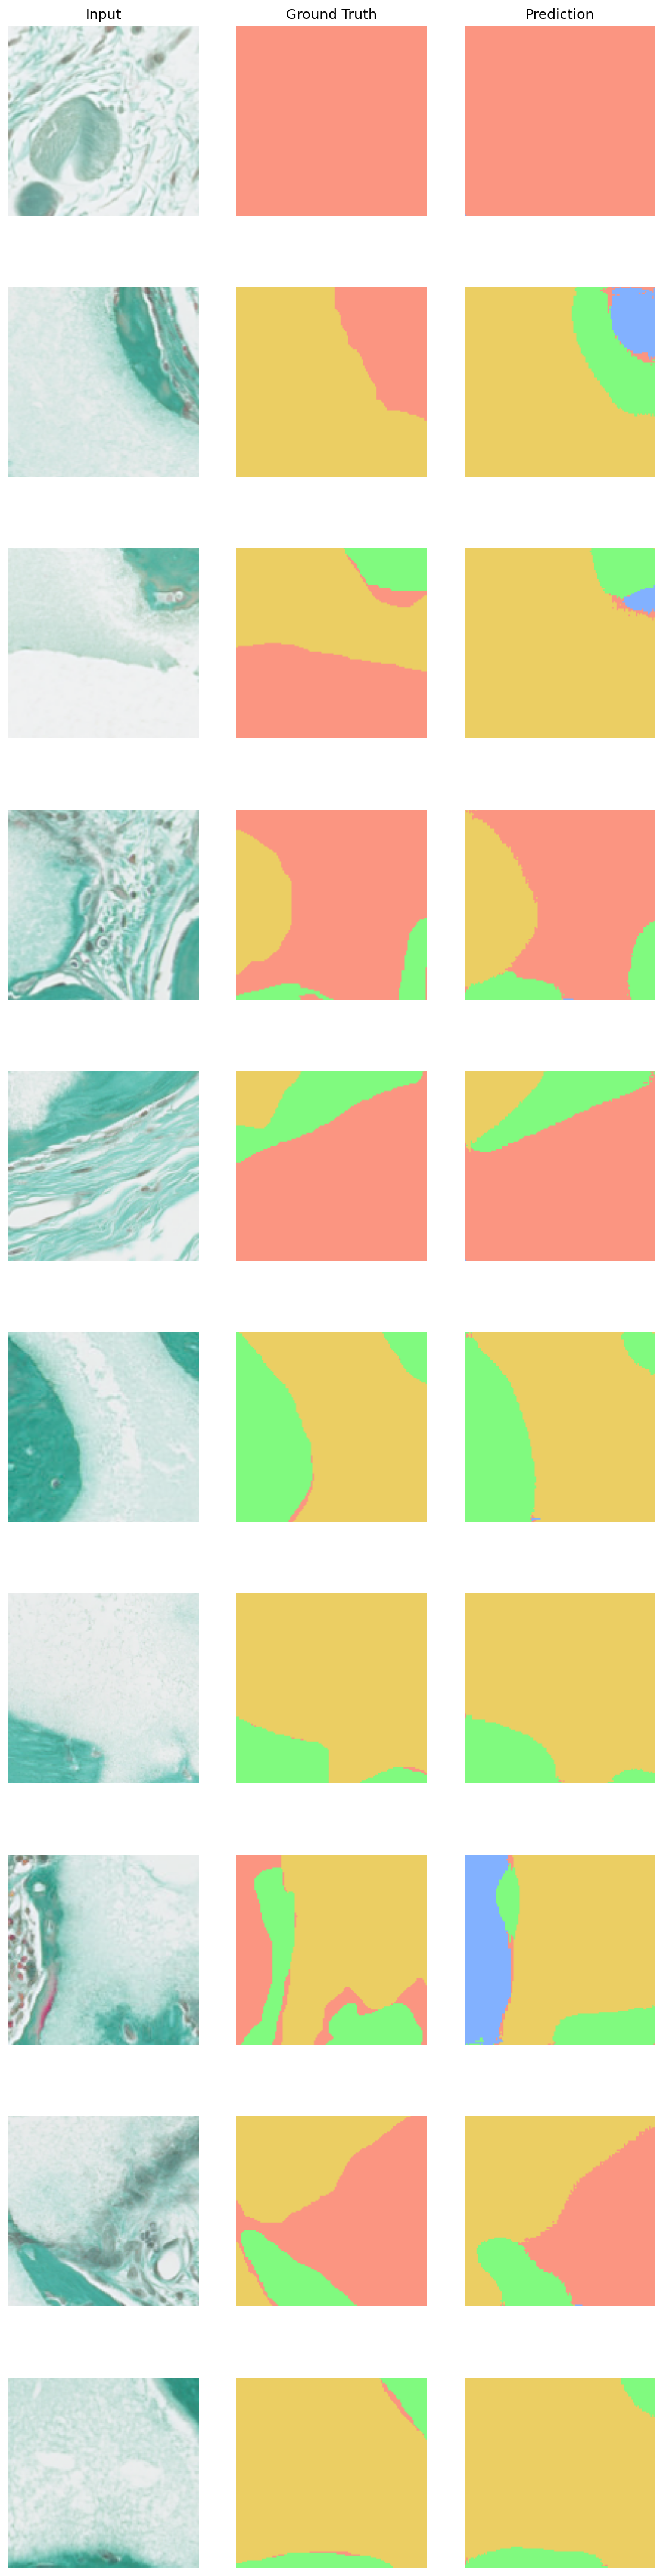

In [43]:
idx = 0
num_images = 10 # min 2

# This will increase the number of classes required
# for an image to be included in the test
# this value is incremented in the loop
req_class_count = 1
max_class_count = 3

# Create a figure
fig, axs = plt.subplots(num_images, 3, figsize=(10, 4 * num_images))#, facecolor="grey")

take_amount = 1200 // batch_size
for batch_images, batch_labels in iter(test_dataset.take(take_amount)):

    for test_image, test_label in zip(batch_images, batch_labels):

        # Check if any element in the last dimension is 1
        has_ones = tf.reduce_any(test_label == 1, axis=[0, 1])
        # Count the number of dimensions with at least one 1 value
        class_count = tf.reduce_sum(tf.cast(has_ones, tf.int32))

        # If number of classes not found in label (req_class_count)
        if class_count != req_class_count:
            continue

        # this increments the miniumum class requirement
        req_class_count = min(req_class_count + 1, max_class_count)

        # Expand dims to (1, x, y, c)
        infr_test_image = tf.expand_dims(test_image, axis=0)

        predicted_label = model.predict(infr_test_image, verbose=0)
        predicted_label = np.squeeze(predicted_label)

        # print(f"Predicted label min: {np.min(predicted_label)}")
        # print(f"Predicted label max: {np.max(predicted_label)}")

        # Display the original image
        axs[idx][0].imshow(np.squeeze(test_image))
        axs[idx][0].axis('off')
        if idx < 1:
            axs[idx][0].set_title("Input")

        # Display the original label
        original_label = label_to_color_image(test_label)
        axs[idx][1].imshow(original_label)
        axs[idx][1].axis('off')
        if idx < 1:
            axs[idx][1].set_title("Ground Truth")

        # Display the predicted label
        predicted_label = pred_processing(predicted_label)
        axs[idx][2].imshow(predicted_label)
        axs[idx][2].axis('off')
        if idx < 1:
            axs[idx][2].set_title("Prediction");

        idx += 1

        if idx >= num_images:
            break

    if idx >= num_images:
            break

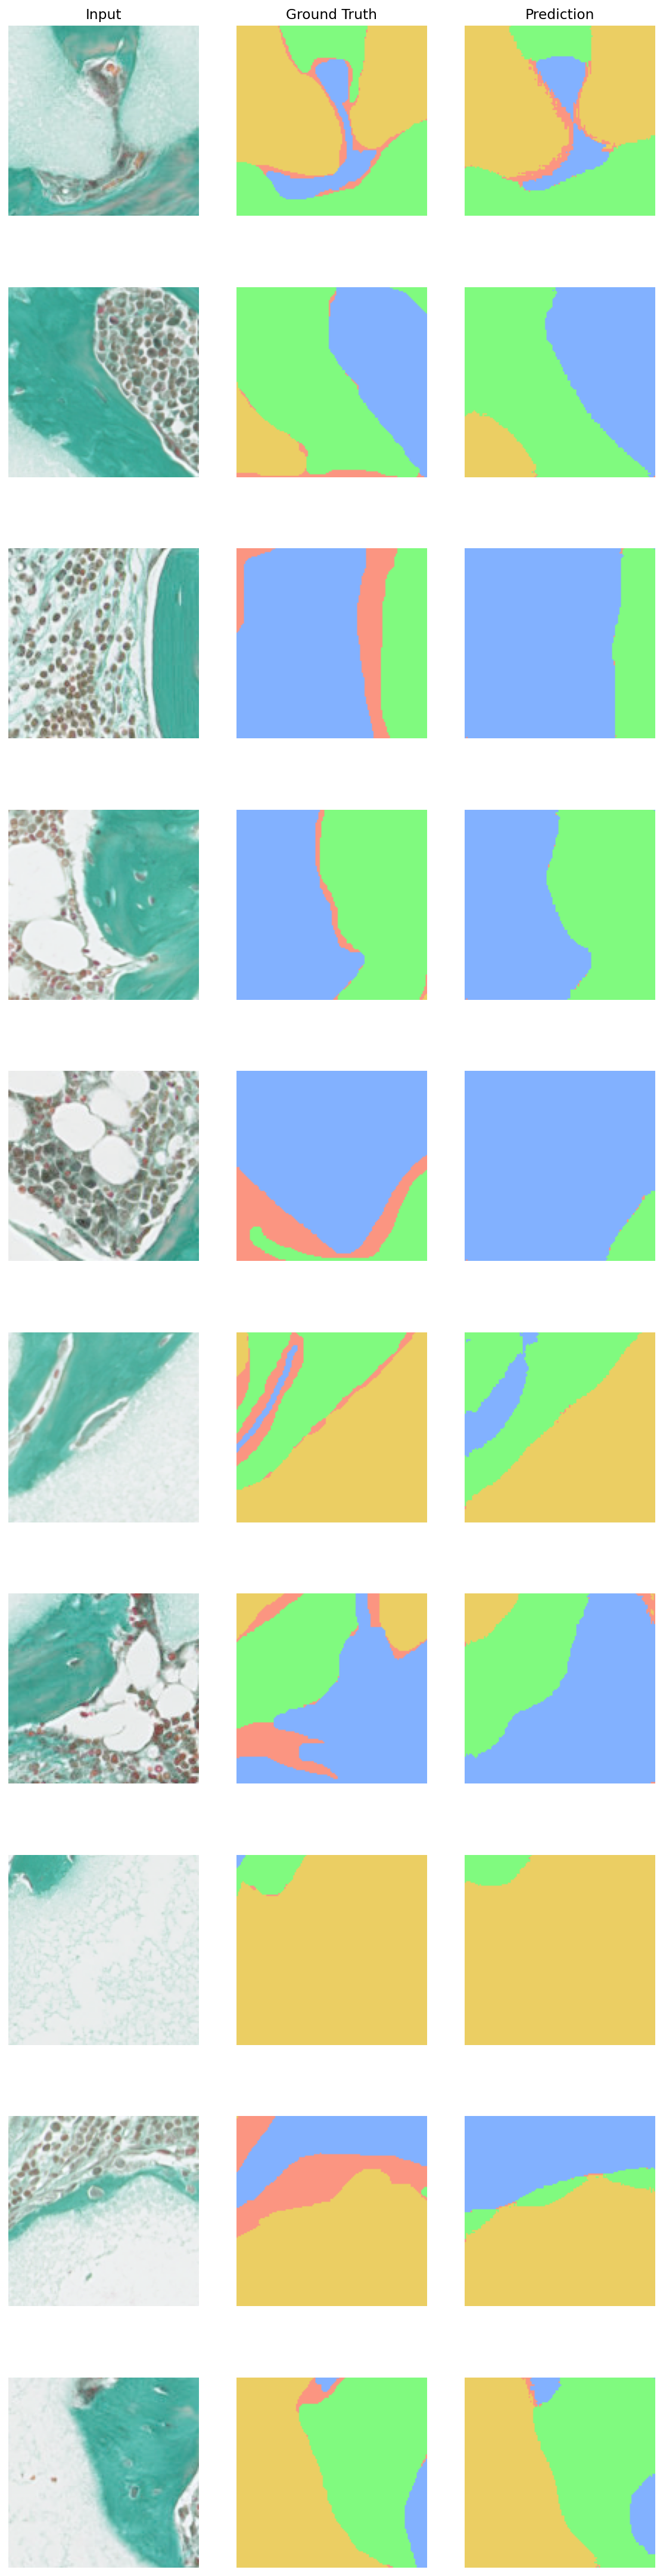

In [44]:
idx = 0
class_idx = 0

num_images = 10 # min 2

# This will increase the number of classes required
# for an image to be included in the test
# this value is incremented in the loop
req_class_count = 2
max_class_count = 2

# Must have at least the classes/label defined below
class_requirement = [3]

# Create a figure
fig, axs = plt.subplots(num_images, 3, figsize=(10, 4 * num_images))#, facecolor="grey")


take_amount = 1200 // batch_size
for batch_images, batch_labels in iter(test_dataset.take(take_amount)):

    for test_image, test_label in zip(batch_images, batch_labels):

        # Check if any element in the last dimension is 1
        classes_present = tf.reduce_any(test_label == 1, axis=[0, 1])
        present_classes_indices = tf.where(classes_present)[:, 0].numpy().tolist()

        # Allow only particular classes
        if not any(elem in present_classes_indices for elem in class_requirement):
            continue

        # this increments the miniumum class requirement
        req_class_count = min(req_class_count + 1, max_class_count)

        # Expand dims to (1, x, y, c)
        infr_test_image = tf.expand_dims(test_image, axis=0)

        predicted_label = model.predict(infr_test_image, verbose=0)
        predicted_label = np.squeeze(predicted_label)

        # print(f"Predicted label min: {np.min(predicted_label)}")
        # print(f"Predicted label max: {np.max(predicted_label)}")

        # Display the original image
        axs[idx][0].imshow(np.squeeze(test_image))
        axs[idx][0].axis('off')
        if idx < 1:
            axs[idx][0].set_title("Input")

        # Display the original label
        original_label = label_to_color_image(test_label)
        axs[idx][1].imshow(original_label)
        axs[idx][1].axis('off')
        if idx < 1:
            axs[idx][1].set_title("Ground Truth")

        # Display the predicted label
        predicted_label = pred_processing(predicted_label)
        axs[idx][2].imshow(predicted_label)
        axs[idx][2].axis('off')
        if idx < 1:
            axs[idx][2].set_title("Prediction");

        idx += 1

        if idx >= num_images:
            break

    if idx >= num_images:
            break

## Test Evaluation

In [45]:
model.evaluate(test_dataset);

555/555 [==============================] - 13s 22ms/step - loss: 0.4507 - accuracy: 0.9386 - mean_iou: 0.7931 - precision: 0.9407 - recall: 0.9370 - 1_iou: 0.9197 - 2_iou: 0.8302 - 3_iou: 0.8432 - 4_iou: 0.5792


## Statistics

In [46]:
# Stats
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_iou = history.history['mean_iou']
val_iou = history.history['val_mean_iou']

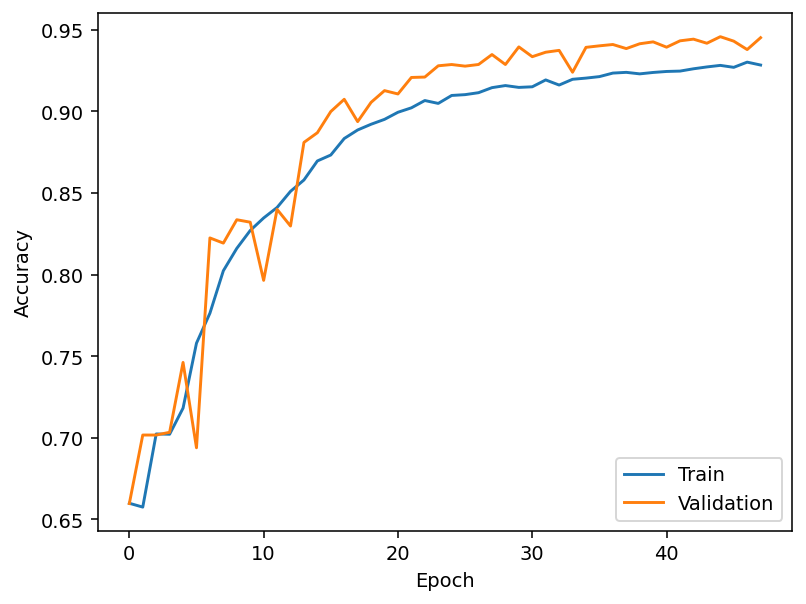

In [47]:
plt.plot(train_acc, label='Train')
plt.plot(val_acc, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

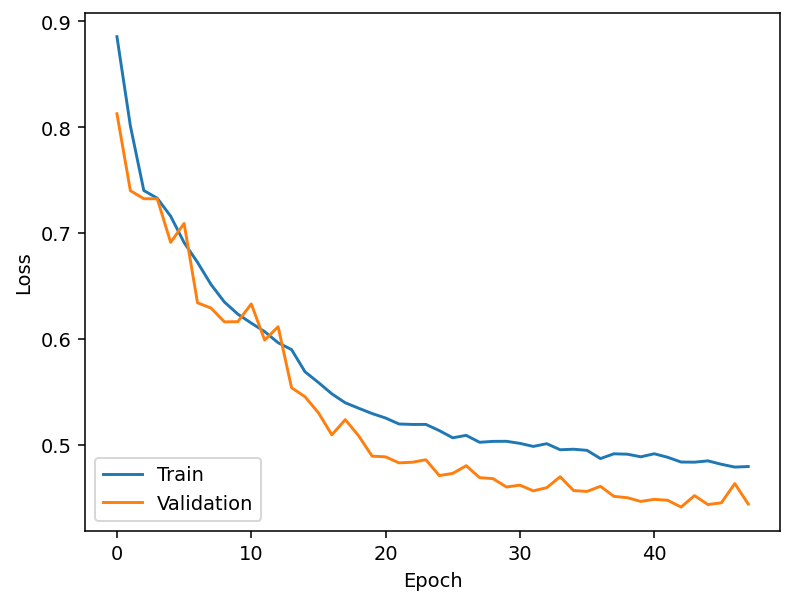

In [48]:
plt.plot(train_loss, label='Train')
plt.plot(val_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

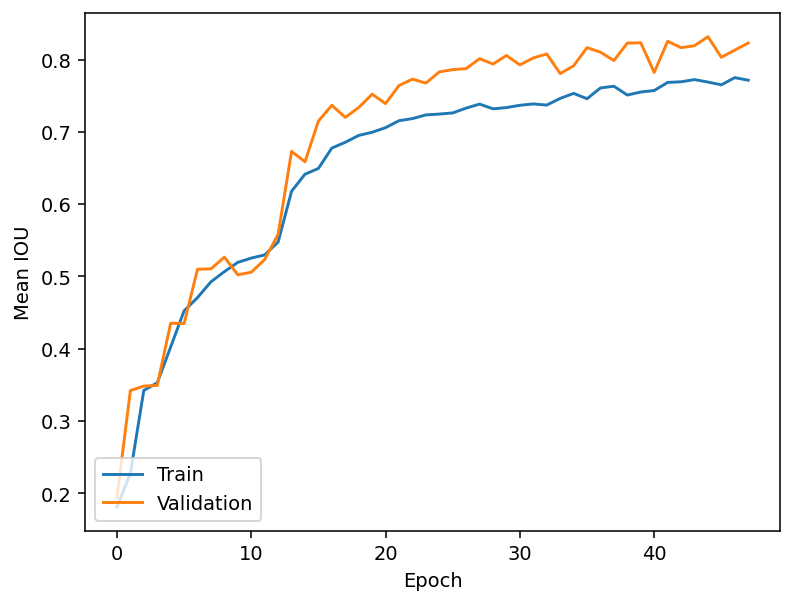

In [49]:
plt.plot(train_iou, label='Train')
plt.plot(val_iou, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean IOU')
plt.legend(loc='lower left')
plt.show()

## Runtime Unassign

In [50]:
# runtime.unassign()